### 2. Retropropagación en una red densa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Para la segunda parte de la tarea 1 vamos a programar una red densa con dos capas oculltas para un problema de clasificación binaria usando una función logística como función de activación:

$$
\sigma(z)=\frac{1}{1+e^{-z}}
$$


In [ ]:
def s(z):
  s = 1/(1+np.exp(-z))
  return s

Esta función se ve así:

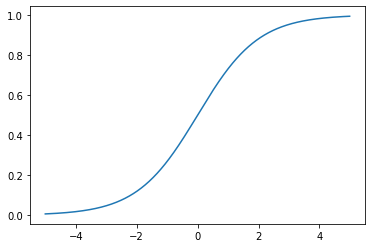

In [ ]:
z = np.arange(-5, 5, 0.01)
plt.plot(z, s(z))

Para la retropropagación vamos a usar la derivada de esta función, dada por:

$$
\sigma'(z) = \frac{e^{-x}}{(1 + e^{-x})^2}
$$

In [ ]:
def d_s(x):
  d = (np.exp(-x))/(1 + np.exp(-x))**2
  return d

$\sigma '$ se ve así:

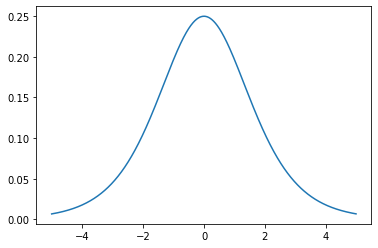

In [ ]:
plt.plot(z, d_s(z))

Para calcular el error, vamos a usar la entropía cruzada binaria, por ser este un problema de clasificación binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [ ]:
def ecb(y, y_hat):
    y_hat[y_hat == 0] = np.nextafter(0., 1.)
    y_hat[y_hat == 1] = np.nextafter(1., 0.)
    return -(np.log(y_hat[y == 1]).sum() + np.log(1 - y_hat[y == 0]).sum())

Para cuantificar cómo va nuestro modelo, definimos la exactitud como el cociente entre las salidas correctas entre las totales:

In [ ]:
def exactitud(y, y_hat):
    return (y == y_hat).mean() * 100

## Propagación hacia adelante

Como la red está compuesta de 2 capas ocultas densas más la salida, tenemos 3 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$, $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$, $\{\mathbf{W}^{\{3\}}, \mathbf{b}^{\{3\}}\}$. 

Nuestra red se vería así:

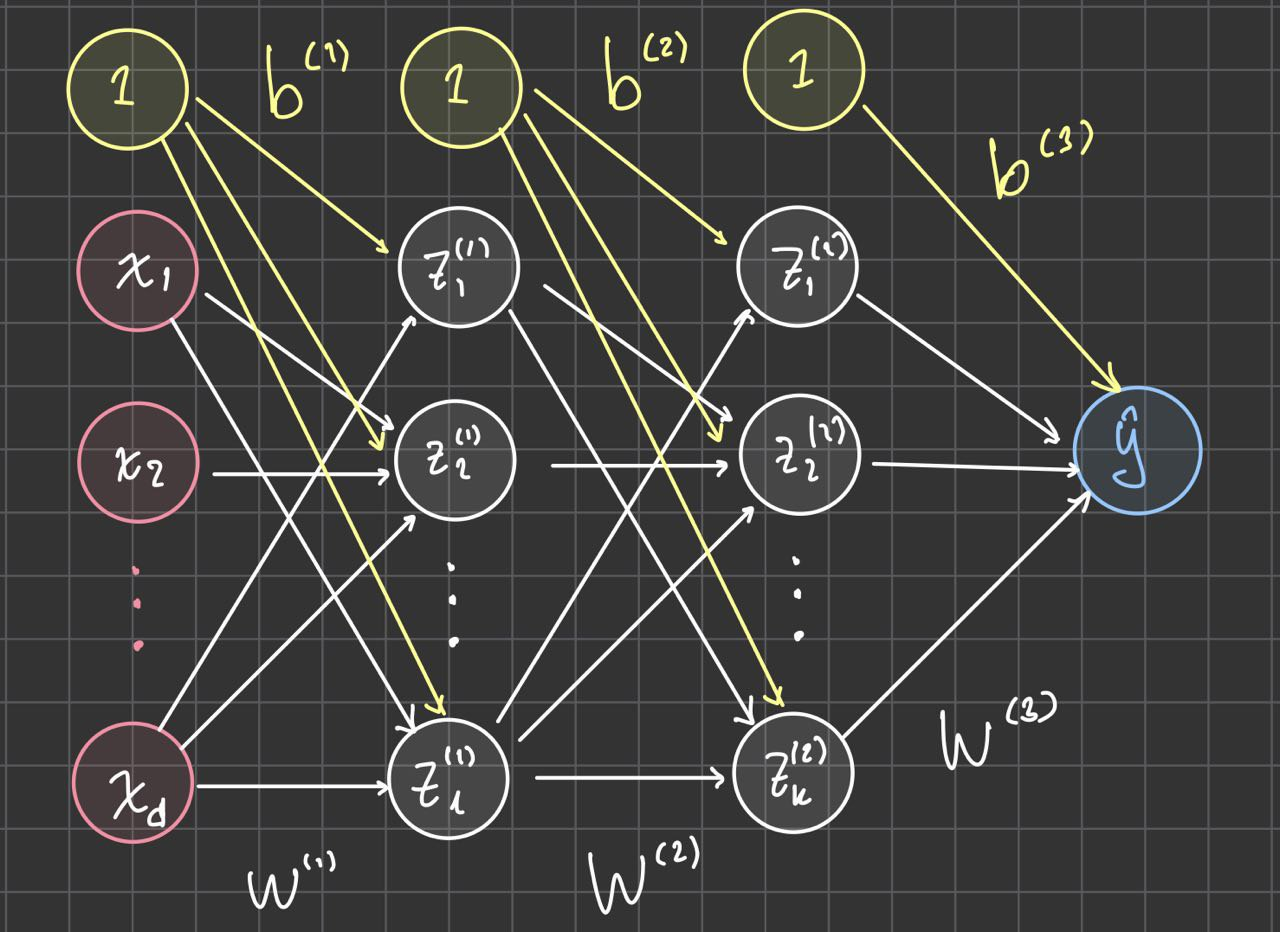

La propagación hacia adelante estría dada por:

$$
	\begin{split}
				\mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
				\mathbf{z}^{\{2\}} & =  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{a}^{\{2\}} & =  \sigma(\mathbf{z}^{\{2\}}) \\
				\mathbf{z}^{\{3\}} & =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{a}^{\{3\}} & =  \sigma(\mathbf{z}^{\{3\}})\\
				\mathbf{z}^{\{4\}} & =  \mathbf{W}^{\{3\}} \cdot \mathbf{a}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
				\mathbf{a}^{\{4\}} & =  \sigma(\mathbf{z}^{\{4\}})\\
				\hat{y}^{(i)} & =  \mathbf{a}^{\{4\}}
			\end{split}
$$

Para propagar hacia adelante, usaré la siguiente función que devuelve la activación para una capa dadas W, b y la activación de la capa anterior:

In [ ]:
def adelante(a1, W, b):
  z2 = np.dot(W.T, a1) + b
  a2 = s(z2)
  return z2, a2

Así:
$$
	\begin{split}
				\mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
				\mathbf{a}^{\{2\}} & =  \text{adelante}(\mathbf{a}^{\{1\}}) \\
				\mathbf{a}^{\{3\}} & =  \text{adelante}(\mathbf{a}^{\{2\}})\\
				\mathbf{a}^{\{4\}} & =  \text{adelante}(\mathbf{a}^{\{3\}})\\
				\hat{y}^{(i)} & =  \mathbf{a}^{\{4\}}
			\end{split}
$$

In [ ]:
def hacia_adelante(X,W1,b1,W2,b2,W3,b3):
  a1 = X[:, np.newaxis]
  #print('a1 = X')
  z2, a2 = adelante(a1, W1, b1)
  #print('z2, a2 = adelante(a1, W1, b1)')
  z3, a3 = adelante(a2, W2, b2)
  #print('z3, a3 = adelante(a2, W2, b2)')
  z4, y_hat = adelante(a3, W3, b3)
  #print('z4, y_hat = adelante(a3,  W3, b3)')

  return z2, a2, z3, a3, z4, y_hat

## Retropropagación
Ahora, usando la regla de la cadena, vamos a calcular los gradientes respecto de los pesos, esto desde la salida hasta la entrada:


Primero obtenemos la derivada del ECB respecto de los pesos $W^{\{3\}}$ como:
$$
 \text{dW3} = (\hat{y} - y) \mathbf{a}^{\{3\}},
$$
en nuestro modelo hemos llamado $\text{dz4}$ a $(\hat{y}^{(i)} - y) $, ya que se usará en un cálculo posterior.

Para la derivada del ECB respecto del sesgo $b^{\{3\}}$ resulta ser sólo $\text{dz4}$.

\\

Para la derivado del ECB respecto a los pesos $W^{\{3\}}$ obtenemos:

$$
  \text{dW2} =\mathbf{a}^{\{2\}} ⊗ \big[ (\mathbf{W}^{\{3\}} \cdot (\hat{y} - y)) * \mathbf{a}^{\{3\}} (1-\mathbf{a}^{\{3\}})\big],
$$
en donde $\mathbf{a}^{\{3\}} (1-\mathbf{a}^{\{3\}})$ no es más que la derivada de la sigmoide evaluada en $z^{\{3\}}$. Si en nuestro modelo nombramos $\text{dz3}$ a $(\mathbf{W}^{\{3\}} \cdot (\hat{y} - y)) * \mathbf{a}^{\{3\}} (1-\mathbf{a}^{\{3\}})$ tenemos:
$$
  \text{dW2} = \mathbf{a}^{\{2\}} ⊗ \text{dz3}.
$$

La derivada del ECB respecto del sesgo $b^{\{2\}}$ resulta ser $\text{dz3}$.

\\

Al calcular la derivadada del ECB respecto a los pesos $W^{\{1\}}$ obtenemos:

$$
\begin{split}
  \text{dW1} =\mathbf{X} ⊗ & \big[ \mathbf{W}^{\{2\}} \cdot \big\{ (\mathbf{W}^{\{3\}} \cdot (\hat{y} - y)) * \mathbf{a}^{\{3\}} (1-\mathbf{a}^{\{3\}}) \big\} * \mathbf{a}^{\{2\}} (1-\mathbf{a}^{\{2\}})  \big]\\
   =\mathbf{X} ⊗ & \big[ \mathbf{W}^{\{2\}} \cdot \text{dz3} * \mathbf{a}^{\{2\}} (1-\mathbf{a}^{\{2\}})\big]
\end{split}
$$

si llamamos  $\text{dz2}$ a $\mathbf{W}^{\{2\}} \cdot \text{dz3} * \mathbf{a}^{\{2\}} (1-\mathbf{a}^{\{2\}})$ tenemos:

$$
\text{dW1} =\mathbf{X} ⊗ \text{dz2}
$$
Y, así como en los casos anteriores, la derivada de La derivada del ECB respecto del sesgo $b^{\{1\}}$ es $\text{dz2}$.

In [ ]:
def retro(x, y_hat, y, W1, z2, a2, W2, z3, a3, W3):
  dz4 = y_hat - y

  dW3 = np.outer(a3, dz4)
  db3 = dz4

  dz3 = np.dot(W3, dz4) * d_s(z3)

  dW2 = np.outer(a2, dz3)
  db2 = dz3
  
  dz2 = np.dot(W2, dz3) * d_s(z2)
            
  dW1 = np.outer(x, dz2)
  db1 = dz2

  return dW3, db3, dW2, db2, dW1, db1

Una vez calculadas integramos la retropropagación al modelo:

In [ ]:
def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
        
    # Inicialización de las matrices de pesos W y sesgos b
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))

    W2 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_ocultas, n_ocultas)
    b2 = np.zeros((n_ocultas, 1))

    W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b3 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))

    for i in range(n_epocas):
        for j in range(n_ejemplos):
            
            #Propagamos hacia adelante:
            z2, a2, z3, a3, z4, y_hat = hacia_adelante(X[j], W1, b1, W2, b2, W3, b3)
            
            #Retropropagación:
            dW3, db3, dW2, db2, dW1, db1 = retro(X[j], y_hat, y[j], W1, z2, a2, W2, z3, a3, W3)

            #Actualizamos todos los pesos y sesgos juntos
            W3 = W3 - alpha * dW3
            b3 = b3 - alpha * db3
            W2 = W2 - alpha * dW2
            b2 = b2 - alpha * db2
            W1 = W1 - alpha * dW1
            b1 = b1 - alpha * db1

            y_predicha[j] = y_hat
            

        # calculamos la pérdida en la época
        perdidas[i] = ecb(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(i, perdidas[i], exactitudes[i]))
        #print('W1 = {0}'.format(W1))
        #print('W2 = {0}'.format(W2))

    return W1, W2, W3, perdidas, exactitudes

##Entrenamiento

Para el entrenamiento voy a usar la base de datos del Titanic que trae seaborn

In [ ]:
import seaborn as sns
import pandas as pd
titanic = sns.load_dataset('titanic')

In [ ]:
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Como la columna de deck tiene muchos nulos, vamos a deshacernos de ella. Para la columna de la edad, vamos a sustituir los valores faltantes por la edad promedio promedio. Además vamos a tirar los renglones que tienen entradas nulas en embark y embark_town.


In [ ]:
titanic.drop('deck', 1, inplace=True)
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())
titanic.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
titanic.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64

Reescalamos os valores reales para que quepan entre 0 y 1:

In [ ]:
titanic[['age','fare']] -= titanic[['age','fare']].min()
titanic[['age','fare']] /= titanic[['age','fare']].max()

Voy a crear dummies de la siguiente manera, por simplicidad, porque sólo nos interesa la retropropagación en este ejercicio. Probablemente esta no sea la mejor manera pero sí fue la más fácil:

In [ ]:
titanic = pd.get_dummies(titanic, columns = ['embarked', 'who','class', 'embark_town'])
titanic =pd.get_dummies(titanic, columns=['sex', 'alive', 'alone',  'adult_male'], drop_first=True)

In [ ]:
titanic

,survived,pclass,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S,who_child,...,class_First,class_Second,class_Third,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,sex_male,alive_yes,alone_True,adult_male_True
0,0,3,0.271174,1,0,0.014151,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
1,1,1,0.472229,1,0,0.139136,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,1,3,0.321438,0,0,0.015469,0,0,1,0,...,0,0,1,0,0,1,0,1,1,0
3,1,1,0.434531,1,0,0.103644,0,0,1,0,...,1,0,0,0,0,1,0,1,0,0
4,0,3,0.434531,0,0,0.015713,0,0,1,0,...,0,0,1,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0.334004,0,0,0.025374,0,0,1,0,...,0,1,0,0,0,1,1,0,1,1
887,1,1,0.233476,0,0,0.058556,0,0,1,0,...,1,0,0,0,0,1,0,1,1,0
888,0,3,0.367921,1,2,0.045771,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
889,1,1,0.321438,0,0,0.058556,1,0,0,0,...,1,0,0,1,0,0,1,1,1,1


In [ ]:
X = titanic.drop('alive_yes', axis=1).to_numpy()
y = titanic['alive_yes'].to_numpy()

Ahora sí, a lo que te truje:

In [ ]:
np.random.seed(0)
W1, W2, W3, perdidas, exactitudes = retropropagacion(X, y, alpha = 0.001, n_epocas = 150, n_ocultas = 10)

Epoch 0: Pérdida = 594.4895075634868 Exactitud = 61.754780652418454
Epoch 1: Pérdida = 592.9370492843102 Exactitud = 61.754780652418454
Epoch 2: Pérdida = 592.4226811707672 Exactitud = 61.754780652418454
Epoch 3: Pérdida = 592.1488952269113 Exactitud = 61.754780652418454
Epoch 4: Pérdida = 591.9313231433895 Exactitud = 61.754780652418454
Epoch 5: Pérdida = 591.7270089445433 Exactitud = 61.754780652418454
Epoch 6: Pérdida = 591.5258226829989 Exactitud = 61.754780652418454
Epoch 7: Pérdida = 591.3251963245236 Exactitud = 61.754780652418454
Epoch 8: Pérdida = 591.124254122688 Exactitud = 61.754780652418454
Epoch 9: Pérdida = 590.9224711486966 Exactitud = 61.754780652418454
Epoch 10: Pérdida = 590.7193795323388 Exactitud = 61.754780652418454
Epoch 11: Pérdida = 590.5145103200734 Exactitud = 61.754780652418454
Epoch 12: Pérdida = 590.3073846301506 Exactitud = 61.754780652418454
Epoch 13: Pérdida = 590.0975131632733 Exactitud = 61.754780652418454
Epoch 14: Pérdida = 589.8843960162751 Exactit

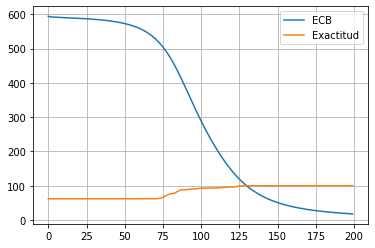

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

Parece que le cuesta un poco al principio, pero despúes de la época 75, el error decrece bastante rápido. Me imagino que puede ser porque, como construimos las dummies para las variables no binarias como una neurona para cada categoría, es hasta que cambia por completo el valor de los pesos que conectan con esa neurona, que el error puede empezar a decaer y lo hace de manera abrupta. Esto también podría sugerirme que sí hay grupos de personas muy específicos que muestran una tedncia muy fuerte a alguna de las clases (ser encontrados vivos o no).